In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models
from data import fashion_mnist
from trainer import Trainer, Hyperparameters
from models import SoftmaxRegression

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [2]:
fashion_mnist_dataset = fashion_mnist()

In [3]:
sample_train_item = fashion_mnist_dataset.train.data[0]

In [4]:
provider = lambda hyperparams: Trainer(
    model=SoftmaxRegression(
        input_d=sample_train_item.shape[0] * sample_train_item.shape[1],
        output_d=len(fashion_mnist_dataset.train.classes)
    ),
    dataset=fashion_mnist_dataset,
    loss=nn.CrossEntropyLoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [5]:
trainer = provider(Hyperparameters(
    opt=dict(
        lr = 1e-3
    ),
    general=dict(
        num_epochs = 30,
        batch_size = 256
    )
))

In [6]:
train_result = trainer.train(10)

<Axes: >

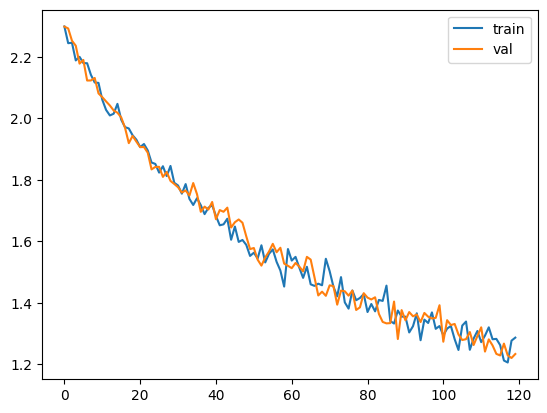

In [7]:
train_result.plot()

In [9]:
_, val_dataloader = fashion_mnist_dataset.get_dataloaders(256)

In [10]:
results = []
for images, true_labels in val_dataloader:
    scores = trainer.model(images)
    pred_labels = scores.argmax(dim=1)
    results.append(pred_labels.eq(true_labels))

In [11]:
true_labels

tensor([7, 6, 7, 7, 5, 8, 6, 0, 9, 1, 2, 2, 2, 2, 1, 5])

In [12]:
pred_labels

tensor([7, 0, 7, 7, 7, 8, 4, 0, 9, 1, 2, 4, 2, 4, 1, 7])

In [13]:
results[-1]

tensor([ True, False,  True,  True, False,  True, False,  True,  True,  True,
         True, False,  True, False,  True, False])

In [14]:
all_results = torch.cat(results)

In [15]:
all_results.sum() / all_results.shape[0]

tensor(0.6578)